# Load dataset

In [1]:
import pandas as pd
import os 

from data_preprocessing import *

2023-02-09 02:27:42.880598: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [2]:
data_dir = 'data/experiment3/'

X_df = pd.read_csv(f'{data_dir}HA-ANARCI_X.csv')
y_df = pd.read_csv(f'{data_dir}HA-ANARCI_y.csv')['binding']

X_df, y_df = subsample_stemhead(X_df, y_df)

# display(x, y, y.value_counts())

In [ ]:
def to_tf_dataset(x, y, y_label='binding',convert_dict=None):
    x = pd.DataFrame(x)
    if convert_dict:
        x = x.replace(convert_dict)
    y = pd.Series(y).reset_index(drop=True)
    full = pd.concat([x, y],axis=1)
    full.columns = [*list(map(str,list(range(1, x.shape[1]+1)))), y_label]
    display(full.shape)
    return tfdf.keras.pd_dataframe_to_tf_dataset(full, label=y_label)


In [3]:

cdr_char = 'XEDRKHQNSTPGCAVILMFYW-'
test_size = 0.1

pad_len = []
for c in X_df[['VH_AA','VL_AA']]:
    pad_len.append(X_df[c].str.len().max())

codes_dict = {i: c for i, c in enumerate(cdr_char)}

[train_set, val_set, test_set], [X_train_id, X_eval_id, X_test_id], le = encode(X_df, y_df, cdr_char, test_size, pad_len)
[train_set_tf, val_set_tf, test_set_tf] = [to_tf_dataset(x, y, convert_dict=codes_dict) for (x,y) in [train_set, val_set, test_set]] ## debug


/home/yhyeung2/anaconda3/lib/python3.9/site-packages/tensorflow_decision_forests/keras/core.py:1001: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  (dict(dataframe.drop(label, 1)), dataframe[label].values))
2023-02-09 02:27:47.639718: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2023-02-09 02:27:47.667343: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:31:00.0 name: NVIDIA RTX A5000 computeCapability: 8.6
coreClock: 1.695GHz coreCount: 64 deviceMemorySize: 23.69GiB deviceMemoryBandwidth: 715.34GiB/s
2023-02-09 02:27:47.667587: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 1 with properties: 
pciBusID: 0000:4b:00.0 name: NVIDIA RTX A5000 computeCapability: 8.6
coreClock: 1.695GHz coreCount: 64 deviceMemorySize: 23.69GiB deviceMemoryBandwidth: 715.34GiB/s

In [4]:
from tensorflow.keras.utils import to_categorical

(train_x, y_train), (val_x, y_val), (test_x, y_test) = [train_set, val_set, test_set]
y_train, y_val, y_test = to_categorical(y_train), to_categorical(y_val), to_categorical(y_test)
input_length = train_x.shape[1]

# Train

In [5]:
from tensorflow.keras import backend as K
from model_training import *


## deep learning models

### transformer model

In [17]:
K.clear_session()
CDR_model = CDR_model_single(max_length=input_length, n_classes=3)
CDR_model, CDR_history = train_dl_multi(CDR_model, (train_x, y_train), (val_x, y_val))


Epoch 1/256


2023-02-09 02:32:40.655834: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11


 7/60 [==>...........................] - ETA: 1s - loss: 1.0988 - accuracy: 0.3929 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5000 

2023-02-09 02:32:41.405672: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2023-02-09 02:32:41.406475: I tensorflow/stream_executor/cuda/cuda_blas.cc:1838] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


60/60 [==============================] - 6s 47ms/step - loss: 1.0988 - accuracy: 0.3500 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.4854 - val_loss: 1.0992 - val_accuracy: 0.2222 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5000
Epoch 2/256
60/60 [==============================] - 2s 28ms/step - loss: 1.0987 - accuracy: 0.3500 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.4915 - val_loss: 1.1001 - val_accuracy: 0.2222 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.4722
Epoch 3/256
60/60 [==============================] - 2s 28ms/step - loss: 1.0986 - accuracy: 0.3500 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.4964 - val_loss: 1.1006 - val_accuracy: 0.2222 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.4259
Epoch 4/256
60/60 [==============================] - 1s 23ms/step - loss: 1.0985 - accuracy: 0.3500 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5025 - val_loss: 1.1016 - val_accuracy: 0.

In [18]:
eval_df, pred, (label, pred_bool) = test_model_multi(CDR_model, (test_x, y_test, X_test_id), le)
display(eval_df)

(30, 3)


False    17
True     13
dtype: int64

,Id,Label,Prediction,Probability Stem,Probability Head,Probability Others
17,COV2-2710,others,head,0.332844,0.334558,0.332598
3,G32L7,others,head,0.332845,0.334557,0.332599
42,011.7B1,others,head,0.332846,0.334558,0.332596
10,586,others,head,0.332845,0.334558,0.332596
72,317.4K.L062.01_W2,others,head,0.332843,0.334560,0.332597
66,ISD102_P5G4,others,head,0.332845,0.334558,0.332597
73,F11_71_CI-7_LA_P9S3_9,others,head,0.332845,0.334557,0.332598
97,W85-3C05,others,head,0.332846,0.334557,0.332596
55,COV2-2821,others,head,0.332845,0.334558,0.332597
184,S9-3-37,stem,head,0.332845,0.334557,0.332598


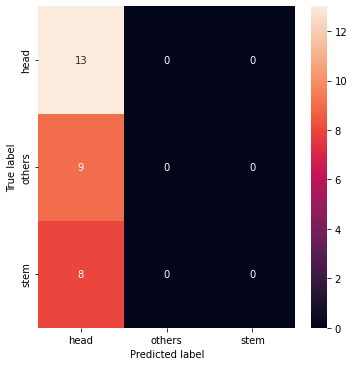

In [19]:
plot_cm_multi(label, pred_bool, le)

### feed forward network

In [20]:
# dense 

K.clear_session()
CDR_model = CDR_model_dense(max_length=input_length, n_classes=3)
CDR_model, CDR_history = train_dl_multi(CDR_model, (train_x, y_train), (val_x, y_val))



Epoch 1/256
60/60 [==============================] - 2s 13ms/step - loss: 3.3398 - accuracy: 0.3708 - precision: 0.3734 - recall: 0.3625 - auc: 0.5412 - val_loss: 2.6724 - val_accuracy: 0.2222 - val_precision: 0.2222 - val_recall: 0.2222 - val_auc: 0.4434
Epoch 2/256
60/60 [==============================] - 0s 6ms/step - loss: 1.8824 - accuracy: 0.3542 - precision: 0.3592 - recall: 0.3083 - auc: 0.4993 - val_loss: 1.1796 - val_accuracy: 0.4074 - val_precision: 0.3810 - val_recall: 0.2963 - val_auc: 0.5686
Epoch 3/256
60/60 [==============================] - 0s 7ms/step - loss: 1.4995 - accuracy: 0.3792 - precision: 0.3668 - recall: 0.3042 - auc: 0.5542 - val_loss: 1.0681 - val_accuracy: 0.4074 - val_precision: 0.5000 - val_recall: 0.2593 - val_auc: 0.6262
Epoch 4/256
60/60 [==============================] - 1s 14ms/step - loss: 1.7641 - accuracy: 0.3375 - precision: 0.3485 - recall: 0.2875 - auc: 0.5033 - val_loss: 1.2613 - val_accuracy: 0.3704 - val_precision: 0.3333 - val_recall: 0.2

60/60 [==============================] - 0s 7ms/step - loss: 0.7268 - accuracy: 0.7125 - precision: 0.7574 - recall: 0.6375 - auc: 0.8628 - val_loss: 1.3833 - val_accuracy: 0.4444 - val_precision: 0.4783 - val_recall: 0.4074 - val_auc: 0.6265
Epoch 34/256
60/60 [==============================] - 0s 7ms/step - loss: 0.8662 - accuracy: 0.6250 - precision: 0.6603 - recall: 0.5750 - auc: 0.8111 - val_loss: 0.9222 - val_accuracy: 0.6296 - val_precision: 0.6250 - val_recall: 0.5556 - val_auc: 0.7668
Epoch 35/256
60/60 [==============================] - 1s 14ms/step - loss: 0.6905 - accuracy: 0.7167 - precision: 0.7619 - recall: 0.6667 - auc: 0.8696 - val_loss: 1.3293 - val_accuracy: 0.4815 - val_precision: 0.5652 - val_recall: 0.4815 - val_auc: 0.6550
Epoch 36/256
60/60 [==============================] - 0s 7ms/step - loss: 0.8037 - accuracy: 0.6375 - precision: 0.6620 - recall: 0.5875 - auc: 0.8304 - val_loss: 1.1226 - val_accuracy: 0.4444 - val_precision: 0.5455 - val_recall: 0.4444 - val_

In [22]:

eval_df, pred, (label, pred_bool) = test_model_multi(CDR_model, (test_x, y_test, X_test_id), le)
display(eval_df)

(30, 3)


False    17
True     13
dtype: int64

,Id,Label,Prediction,Probability Stem,Probability Head,Probability Others
217,61.0|Melbourne_donor_K77,head,others,0.112124,0.279564,0.608311
250,89.0|Melbourne_donor_K77,head,others,0.214718,0.089015,0.696267
291,26.0|Harrison_donor_TIV01,head,others,0.160589,0.328394,0.511017
269,240-14-IgA_2B03,head,others,0.091900,0.393261,0.514840
275,50.0|Melbourne_donor_W85,head,others,0.184145,0.285984,0.529871
216,7.0|Donor_H,head,others,0.361687,0.100064,0.538249
229,SFV015_2F06,head,others,0.289138,0.162592,0.548269
234,2897,head,others,0.243195,0.140270,0.616535
271,1I20,head,others,0.258141,0.298103,0.443756
66,ISD102_P5G4,others,head,0.042573,0.548792,0.408635


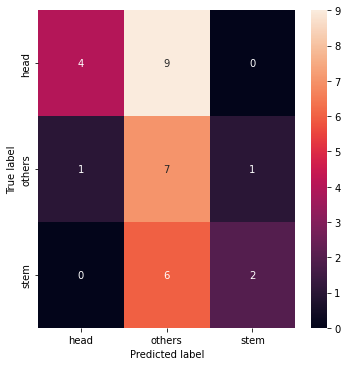

In [23]:
plot_cm_multi(label, pred_bool, le)

### random forest

In [7]:
import tensorflow as tf 

# save model

# model_save_dir = 'models/20230209_multi_exp3/random_forest'
# if not os.path.exists(model_save_dir):
#     os.makedirs(model_save_dir)

# CDR_model.save(model_save_dir)



# load model

model_load_dir = 'model/exp3_random_forest'
CDR_model_multi = tf.keras.models.load_model(model_load_dir, 
                                             custom_objects={
                                                 'recall_m': recall_m,
                                                 'precision_m': precision_m,
                                                 'f1_score': f1_score
                                             })

CDR_model = CDR_model_multi

[INFO kernel.cc:929] Loading model from path
[INFO decision_forest.cc:590] Model loaded with 300 root(s), 14162 node(s), and 185 input feature(s).
[INFO abstract_model.cc:876] Engine "RandomForestGeneric" built
[INFO kernel.cc:797] Use fast generic engine


In [41]:
# skip if use pre-trained model

# K.clear_session()
# CDR_model = tfdf.keras.RandomForestModel(task=tfdf.keras.Task.CLASSIFICATION)
# CDR_model, CDR_history = train_tree_multi(CDR_model, train_set_tf, val_set_tf)


[INFO kernel.cc:727] Start Yggdrasil model training
[INFO kernel.cc:728] Collect training examples
[INFO kernel.cc:389] Number of batches: 4
[INFO kernel.cc:390] Number of examples: 240
[INFO data_spec_inference.cc:286] 3 item(s) have been pruned (i.e. they are considered out of dictionary) for the column 1 (3 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
[INFO data_spec_inference.cc:286] 5 item(s) have been pruned (i.e. they are considered out of dictionary) for the column 10 (3 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
[INFO data_spec_inference.cc:286] 8 item(s) have been pruned (i.e. they are considered out of dictionary) for the column 101 (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
[INFO data_spec_inference.cc:286] 9 item(s) have been pruned (i.e. they are considered out of dictionary) for the column 104 (4 item(s) left) because min_value_count=5 and max_number_of_unique_values=20

[INFO random_forest.cc:568] Training of tree  211/300 (tree index:210) done accuracy:0.558333 logloss:0.948196
[INFO random_forest.cc:568] Training of tree  221/300 (tree index:220) done accuracy:0.566667 logloss:0.950144
[INFO random_forest.cc:568] Training of tree  231/300 (tree index:230) done accuracy:0.575 logloss:0.945939
[INFO random_forest.cc:568] Training of tree  241/300 (tree index:239) done accuracy:0.579167 logloss:0.944667
[INFO random_forest.cc:568] Training of tree  251/300 (tree index:250) done accuracy:0.5875 logloss:0.945369
[INFO random_forest.cc:568] Training of tree  261/300 (tree index:261) done accuracy:0.595833 logloss:0.94522
[INFO random_forest.cc:568] Training of tree  271/300 (tree index:270) done accuracy:0.591667 logloss:0.942619
[INFO random_forest.cc:568] Training of tree  281/300 (tree index:280) done accuracy:0.579167 logloss:0.943097
[INFO random_forest.cc:568] Training of tree  291/300 (tree index:290) done accuracy:0.583333 logloss:0.942006
[INFO r

[INFO kernel.cc:929] Loading model from path
[INFO decision_forest.cc:590] Model loaded with 300 root(s), 14244 node(s), and 185 input feature(s).
[INFO abstract_model.cc:876] Engine "RandomForestGeneric" built
[INFO kernel.cc:797] Use fast generic engine


In [8]:
eval_df, pred, (label, pred_bool) = test_model_multi(CDR_model, (test_set_tf, y_test, X_test_id), le)
display(eval_df)

(30, 3)


True     27
False     3
dtype: int64

,Id,Label,Prediction,Probability Stem,Probability Head,Probability Others
229,SFV015_2F06,head,others,0.240000,0.356666,0.403333
55,COV2-2821,others,stem,0.523333,0.273333,0.203333
114,53.0|PCWilson_donor_236,stem,others,0.266667,0.256667,0.476666


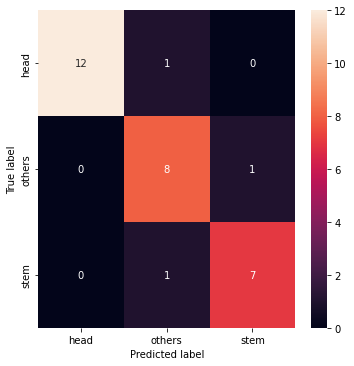

In [9]:
plot_cm_multi(label, pred_bool, le)

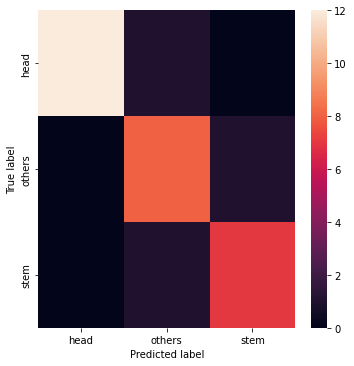

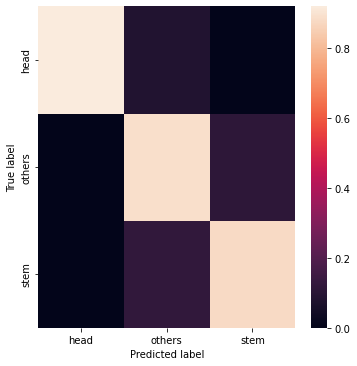

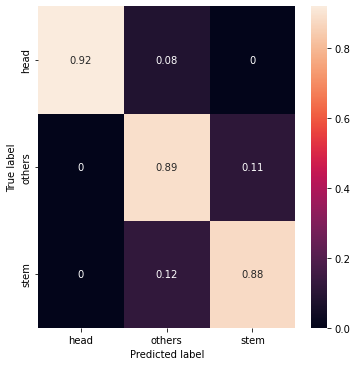

In [16]:
plot_cm_multi(label, pred_bool, le, annot=False)
plot_cm_multi(label, pred_bool, le, relative=True, annot=False)
plot_cm_multi(label, pred_bool, le, relative=True)

# Visualize

## extract decision tree rules

In [10]:
from viz_tree import *

In [11]:
# following tfdf library's default
num_trees = 300
max_depth = 16

rule_df = extract_tree(CDR_model, num_trees, max_depth)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [01:11<00:00,  4.22it/s]


## plot

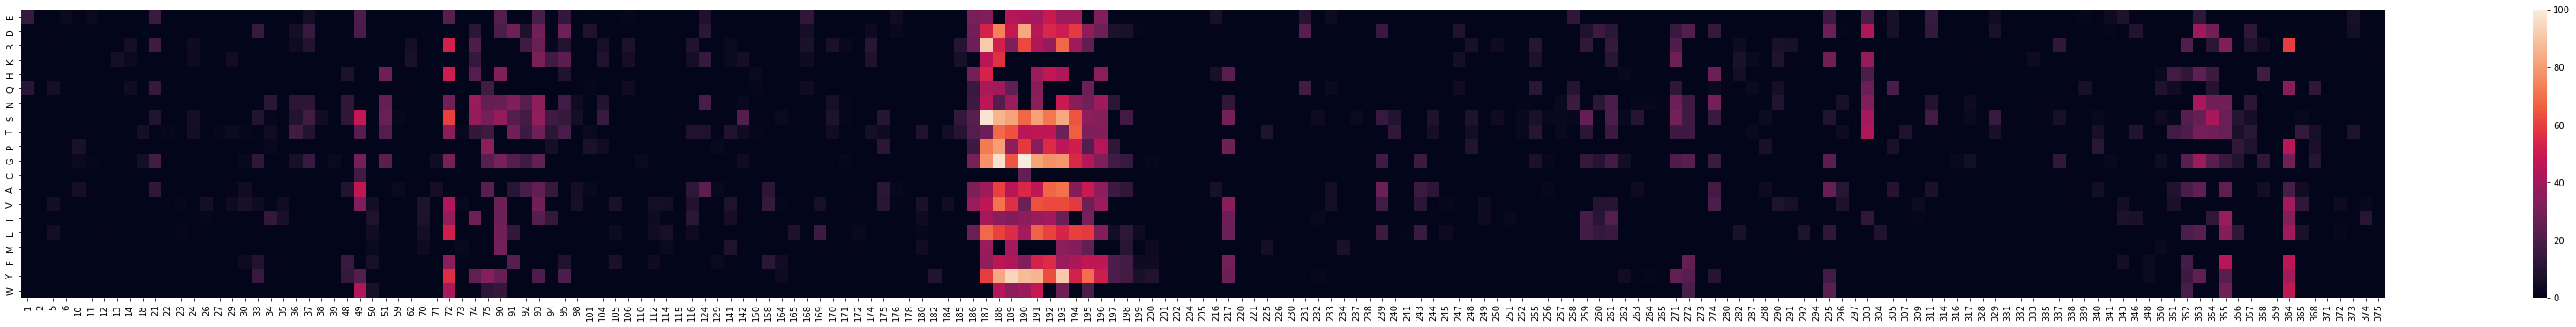

In [12]:
draw_heatmap(rule_df)

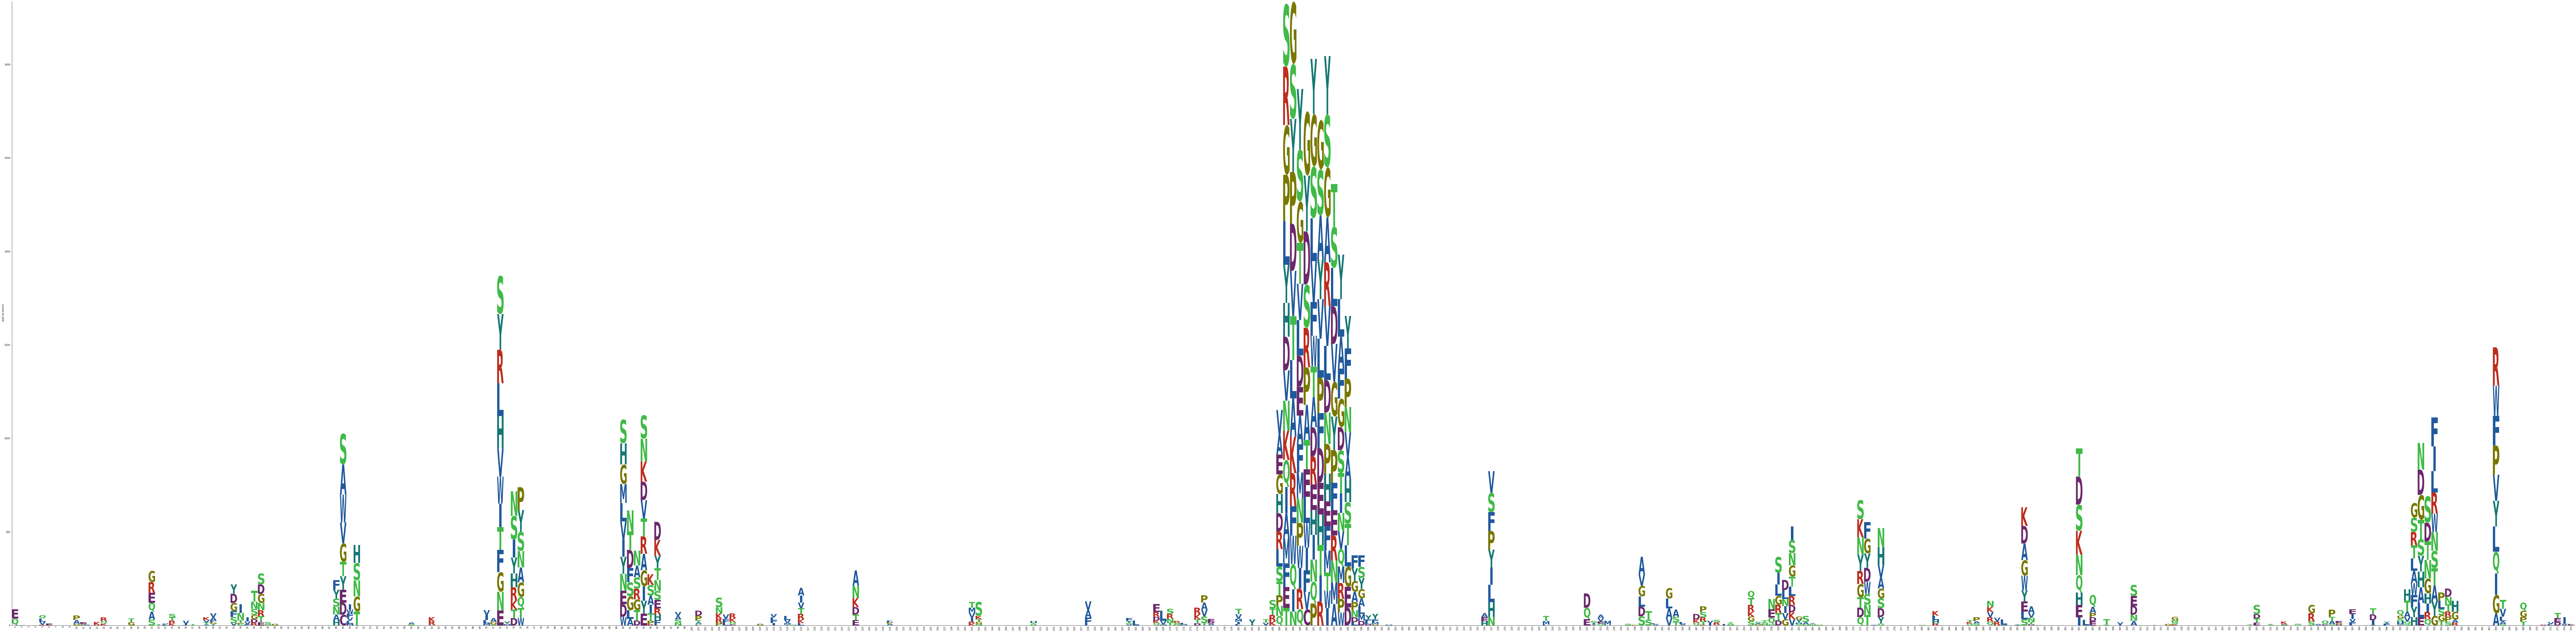

In [13]:
logosequence(rule_df)